<h1>Caso Practico - Aprendizaje Automático</h1>

* Wagner Salazar
* Stefy Franco
* Gustavo Larriva
* Angel

In [63]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
# sns.set(style="whitegrid")

# Carga

In [64]:
df_data = pd.read_csv("./online_shoppers_intention.csv")
print(f"Se cargo correctamente un DataFrame con {df_data.shape[0]} registros y {df_data.shape[1]} columnas")

Se cargo correctamente un DataFrame con 12330 registros y 18 columnas


# Exploración

## Nulos

In [65]:
print(df_data.isna().sum())
print("\n")
print("Por instrucción del caso se deben eliminar los valores nulos del dataset.")
df_data.dropna(inplace=True)

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


Por instrucción del caso se deben eliminar los valores nulos del dataset.


## Revisión variables categóricas

Se parte la exploración de los datos desde las variables categóricas ya que es más sencillo verificar su coherencia

In [66]:
categorical_col = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Revenue"]
for col in df_data[categorical_col].columns:
    print(f"{col}")
    print(f"Categorías: {df_data[col].unique()}")
    print("------------------")

Month
Categorías: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
------------------
OperatingSystems
Categorías: [1 2 4 3 7 6 8 5]
------------------
Browser
Categorías: [ 1  2  3  4  5  6  7 10  8  9 12 13 11]
------------------
Region
Categorías: [1 9 2 3 4 5 6 7 8]
------------------
TrafficType
Categorías: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]
------------------
VisitorType
Categorías: ['Returning_Visitor' 'New_Visitor' 'Other']
------------------
Weekend
Categorías: [False  True]
------------------
Revenue
Categorías: [False  True]
------------------


### Months
* Estandarizar junio June => Jun
* Es necesario establecer un órden para la categoría
* Convertir en categorical

In [67]:
df_data["Month"] = np.where(df_data["Month"] == "June", "Jun", df_data["Month"])
months = ['Feb', 'Mar', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_data["Month"] = pd.Categorical(df_data["Month"], categories=months, ordered=True)

No es necesario revisar el resto de variables categóricas. Ya que no tienen valores nulos y sus clasificaciones corresponde al tipo de varible explicada. A continuación se convierten las variables categóricas en categorical con un orden lógico para las variables con enteros, los object .

In [68]:
for col in categorical_col[1:]:
    # print(df_data[col].dtype)
    if (df_data[col].dtype == "int64"):
        min = df_data[col].min()
        max = df_data[col].max()
        order = np.arange(min, max+1)
        df_data[col] = pd.Categorical(df_data[col], categories=order, ordered=True)
    elif (df_data[col].dtype == "object"):
        df_data[col] = pd.Categorical(df_data[col], categories=df_data[col].unique())

In [69]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12316 non-null  float64 
 1   Administrative_Duration  12316 non-null  float64 
 2   Informational            12316 non-null  float64 
 3   Informational_Duration   12316 non-null  float64 
 4   ProductRelated           12316 non-null  float64 
 5   ProductRelated_Duration  12316 non-null  float64 
 6   BounceRates              12316 non-null  float64 
 7   ExitRates                12316 non-null  float64 
 8   PageValues               12316 non-null  float64 
 9   SpecialDay               12316 non-null  float64 
 10  Month                    12316 non-null  category
 11  OperatingSystems         12316 non-null  category
 12  Browser                  12316 non-null  category
 13  Region                   12316 non-null  category
 14  TrafficType

## Información transaccional

El objetivo del análisis exploratorio es determinar que variables guaradan un correlación fuerte con las visitas al aplicativo web que concluyeron en una venta. Se analizan las variables obtenidas desde el sistema transaccional en dos grupos: 
* Interacciones por tipo de página
    * Administrative
    * Informational
    * ProductRelated
* Duración de las interaciones por tipo de página
    * Administrative_Duration
    * Informational_Duration
    * ProductRelated_Duration

Las variables detalladas arriba se clasificaran contra **Revenue**. Ya está determina si el cliente realizó una compra o no.

### Promedio de interacciones por tipo de página

In [70]:
df_temp_1 = df_data.groupby(by=["Revenue"])[["Administrative", "Informational", "ProductRelated"]].mean().reset_index()
df_temp_1["Revenue"] = np.where(df_temp_1["Revenue"]==True, "Comprador", "No Comprador")
df_temp_1 = df_temp_1.melt(id_vars=["Revenue"], value_vars=["Administrative", "Informational", "ProductRelated"], var_name="TipoPagina", value_name="Value")
df_temp_1 = df_temp_1.sort_values(by=["Revenue", "TipoPagina", "Value"])
display(df_temp_1)

,Revenue,TipoPagina,Value
1,Comprador,Administrative,3.393606
3,Comprador,Informational,0.786164
5,Comprador,ProductRelated,48.210168
0,No Comprador,Administrative,2.120580
2,No Comprador,Informational,0.452248
4,No Comprador,ProductRelated,28.748943


### Promedio de duración de las interacciones por tipo de página

In [71]:
df_temp_2 = df_data.groupby(by=["Revenue"])[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].mean().reset_index()
df_temp_2["Revenue"] = np.where(df_temp_2["Revenue"]==True, "Comprador", "No Comprador")
df_temp_2 = df_temp_2.melt(id_vars=["Revenue"], value_vars=["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"], var_name="TipoPagina", value_name="TotalDuration")
df_temp_2 = df_temp_2.sort_values(by=["Revenue", "TipoPagina", "TotalDuration"])
display(df_temp_2)

,Revenue,TipoPagina,TotalDuration
1,Comprador,Administrative_Duration,119.483244
3,Comprador,Informational_Duration,57.611427
5,Comprador,ProductRelated_Duration,1876.209615
0,No Comprador,Administrative_Duration,73.834208
2,No Comprador,Informational_Duration,30.270759
4,No Comprador,ProductRelated_Duration,1071.347468


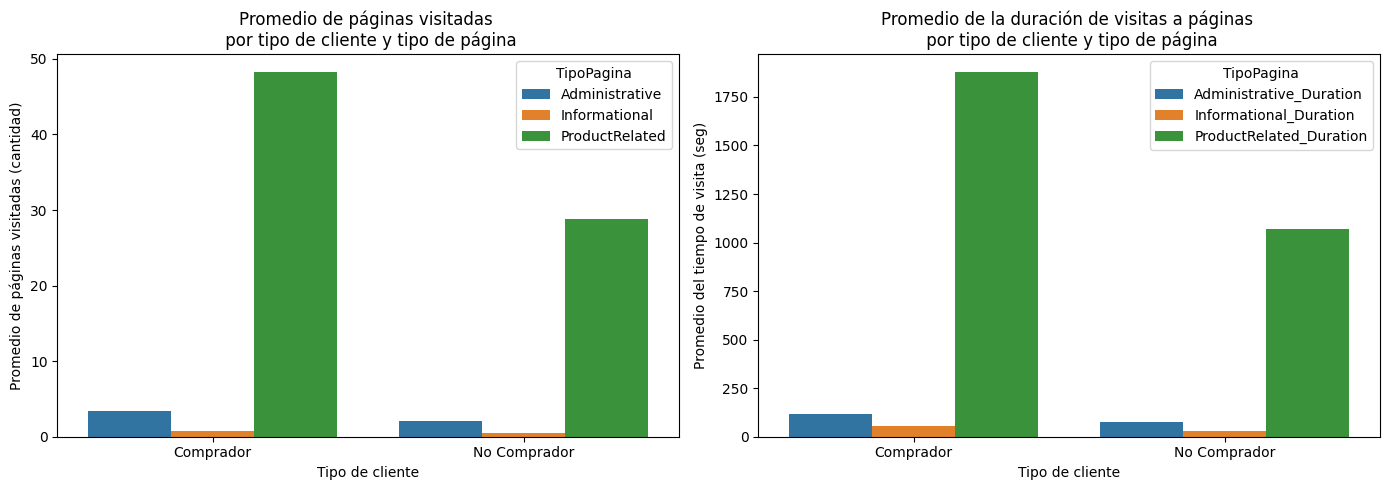

In [72]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x="Revenue", y="Value", hue="TipoPagina", data=df_temp_1, ax=axes[0])
axes[0].set_xlabel("Tipo de cliente")
axes[0].set_ylabel("Promedio de páginas visitadas (cantidad)")
axes[0].set_title("Promedio de páginas visitadas \n por tipo de cliente y tipo de página")
sns.barplot(x="Revenue", y="TotalDuration", hue="TipoPagina", data=df_temp_2, ax=axes[1])
axes[1].set_xlabel("Tipo de cliente")
axes[1].set_ylabel("Promedio del tiempo de visita (seg)")
axes[1].set_title("Promedio de la duración de visitas a páginas \n por tipo de cliente y tipo de página")
plt.tight_layout()
plt.show()

Los gráficos de arriba destacan la importancia de páginas relacionadas al producto (*ProductoRelated*) con los cliente clasificados como compradores. Por una parte los compradores visitan más paginas relacionadas al producto que los no compradores, de igual manera su tiempo de permanencia (duración de la visita) en estas páginas es superior. 

Este comportamiento permite concluir que las páginas relacionadas al producto tiene una influiencia fuerte en las decisiones de compra de los clientes



### Análisis por tipo de visitantes

La data también incluye una clasificación para los tipo de visitantes:
* Returning_Visitor
* New_Visitor
* Other

El objetivo del análisis a continuación es determinar si existe una relación entre las sesiones de cada tipo de visitante y su decisión de compra

,VisitorType,Revenue,SessionCount
0,Returning_Visitor,No Comprador,9067
1,Returning_Visitor,Comprador,1470
2,New_Visitor,No Comprador,1272
3,New_Visitor,Comprador,422
4,Other,No Comprador,69
5,Other,Comprador,16


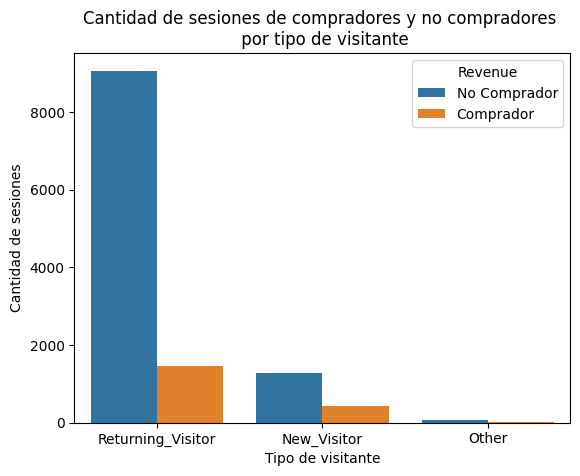

In [73]:
df_temp_3 = df_data.groupby(by=["VisitorType", "Revenue"], observed=False).count()["ProductRelated"].reset_index().rename(columns={"ProductRelated": "SessionCount"})
df_temp_3["Revenue"] = np.where(df_temp_3["Revenue"], "Comprador", "No Comprador")
display(df_temp_3)
sns.barplot(x="VisitorType", y="SessionCount", hue="Revenue", data=df_temp_3)
plt.ylabel("Cantidad de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Cantidad de sesiones de compradores y no compradores \n por tipo de visitante")
plt.show()

A simple vista se podría decir que los visitantes que regresan al sitio (*Returning_Visitor*) realizan más compras, pero para analizar esta información de forma objetiva es necesario manejar los valores a nivel porcentual para cada tipo de visitante y su clasificación de comprador o no comprador

,VisitorType,SessionPercentage_Buyer,SessionPercentage_NonBuyer
0,Returning_Visitor,13.95,86.05
1,New_Visitor,24.91,75.09
2,Other,18.82,81.18


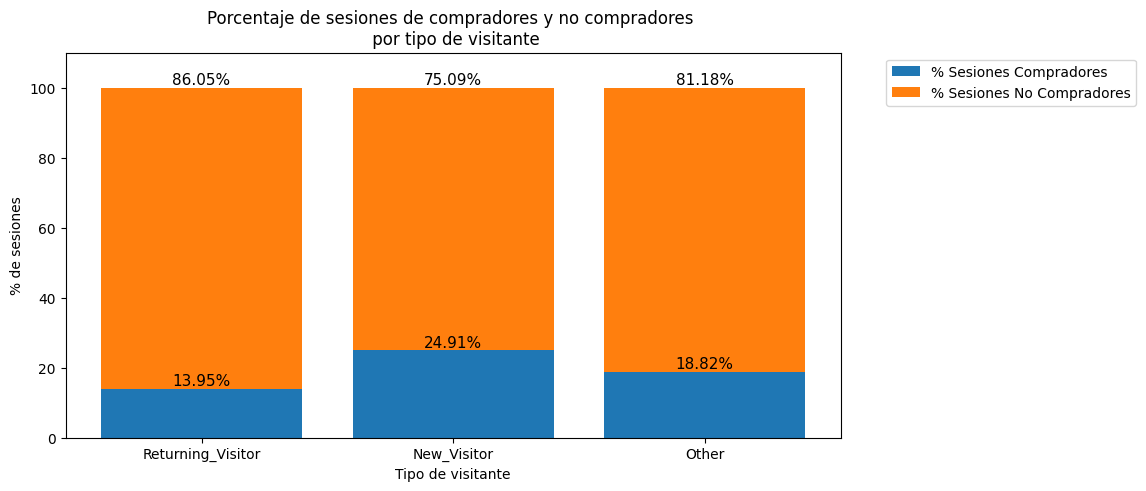

In [74]:
df_temp_4 = pd.DataFrame(df_data.groupby(by=["VisitorType", "Revenue"], observed=False)["ProductRelated"].count().reset_index().rename(columns={"ProductRelated":"SessionCount"}))
df_temp_4["Revenue"] = np.where(df_temp_4["Revenue"], "Comprador", "No Comprador")
df_temp_4.rename(columns={"Revenue": "Tipo de cliente"}, inplace=True)
df_temp_4 = pd.merge(df_temp_4, df_temp_4.groupby(by=["VisitorType"], observed=False).sum(numeric_only=True).reset_index().rename(columns={"SessionCount":"TotalSession"}), on=["VisitorType"], how="left")
df_temp_4["SessionPercentage"] = round((df_temp_4["SessionCount"] / df_temp_4["TotalSession"]) * 100, 2)
df_temp_4 = df_temp_4.pivot(index='VisitorType', columns='Tipo de cliente', values='SessionPercentage').reset_index()
df_temp_4.columns.name = None
df_temp_4.rename(columns={"Comprador":"SessionPercentage_Buyer", "No Comprador": "SessionPercentage_NonBuyer"}, inplace=True)
display(df_temp_4)
plt.figure(figsize=(10,5))

bars1 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_Buyer"], label="% Sesiones Compradores")
bars2 = plt.bar(df_temp_4["VisitorType"], df_temp_4["SessionPercentage_NonBuyer"], bottom = df_temp_4["SessionPercentage_Buyer"], label="% Sesiones No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_4["SessionPercentage_Buyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_4["SessionPercentage_NonBuyer"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Porcentaje de sesiones de compradores y no compradores \n por tipo de visitante")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

A pesar que la cantidad de sesiones de visitantes que retornan al sitio es mayor estos en su mayoría no realizan compras, unicamente un 13.9% del total de Returning_Visitor realizan una compra en la página. Mientras que el 24.9% de nuevos visitantes realizan compras.

Esto permite concluir que la página influye más en la decisión de compra de nuevos visitantes que en la de visitantes antiguos.

### Google Analytics Metrics

Como parte del dataset se incluyen las métricas de *engagement* o compromiso. La intención del análisis a continuación es determinar la relación que mantienen estas métricas con la clasificación de la sesión del cliente como comprador o no comprador.

Se consideran las siguientes variables
* BounceRates
* ExitRates
* PageValues

#### ExitRates vs BounceRates

ExitRates: Por definición es una metrica que muestra el porcentaje de salidas desde una página. En este dataset mostrado en sesiones de usuario es el promedio de la *tasa de salida* de páginas visitadadas en cada sesión registrada

BounceRates: Por definicion es un métrica que muestra el porcentaje de visitantes que salieron del sitio después de visitar solo una página. En este dataset mostrado en sesiones es el promedio de la *tasa de rebote* de las páginas visitada por el usuario durante la sesión

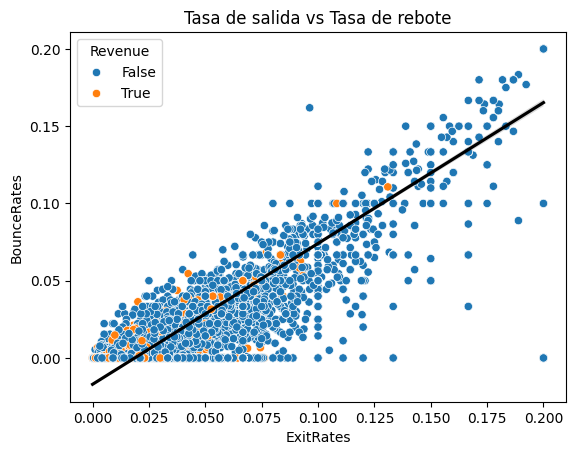

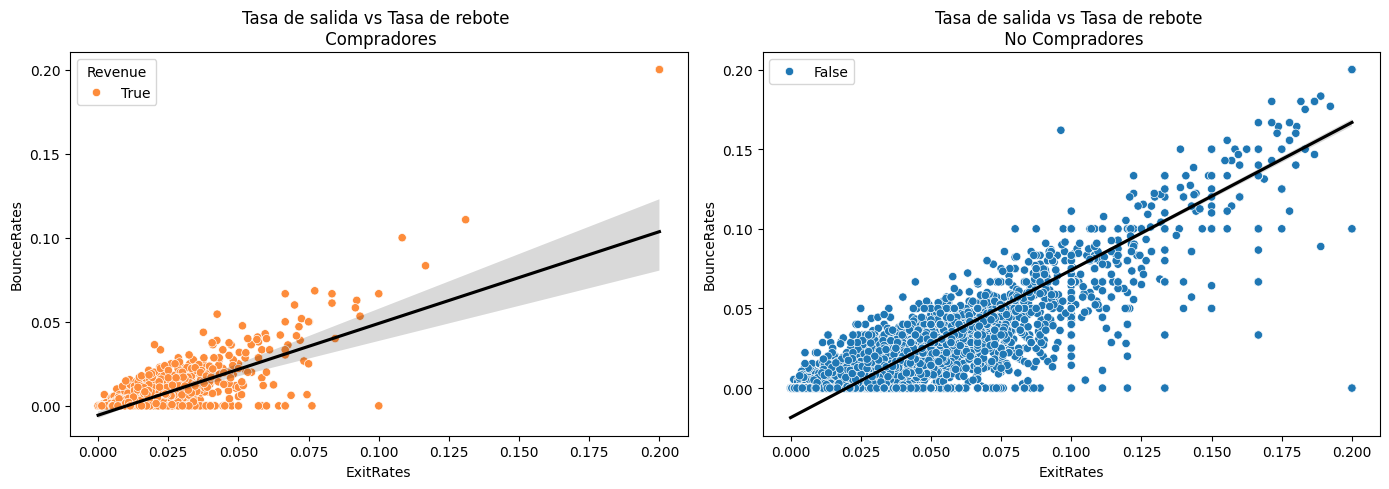

In [75]:
sns.scatterplot(data=df_data, x="ExitRates", y="BounceRates", hue="Revenue")
sns.regplot(data=df_data, x="ExitRates", y="BounceRates", scatter=False, color="Black")
plt.title("Tasa de salida vs Tasa de rebote")


fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.scatterplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[0], palette="Oranges")
sns.regplot(data=df_data[df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[0])
axes[0].set_title("Tasa de salida vs Tasa de rebote \n Compradores")

sns.scatterplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", hue="Revenue", ax=axes[1])
sns.regplot(data=df_data[~df_data["Revenue"]], x="ExitRates", y="BounceRates", scatter=False, color="Black", ax=axes[1])
axes[1].set_title("Tasa de salida vs Tasa de rebote \n No Compradores")

plt.legend()
plt.tight_layout()
plt.show()

Los gráficos de puntos muestran una correlación positiva entre *ExitRates* y *BounceRates* es decir, a mayor tasa da salida mayor tasa de rebote. 

Para determinar si estas variables mantienen relación con la influencia de compra se realiza el segundo gráfico separando las sesiones que culminan con una compra y las sesiones que no. A la izquierda en color naranja se muestran las sesiones de clientes que compraron. Este gráfico confirma la correlación positiva de las variables y permite concluir que valores bajos en ambas variables (tasa de salida y rebote) son indicativos de una compra.

#### PageValues

Por definición esta metrica está relacionada con las compras realizadas a través de sitio. Generalmente permite evaluar que tan influyente es una página en las decisiones de compra de un usuario. Considerando que la data está expresada en sesiones este valor es el promedio de los indicadores de cada página visitada por el usuario durante la sesión. 

,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10408.0,1.978656,9.078234,0.0,0.000000,0.000000,0.000000,246.758590
True,1908.0,27.264518,35.191954,0.0,3.641144,16.758134,38.897742,361.763742


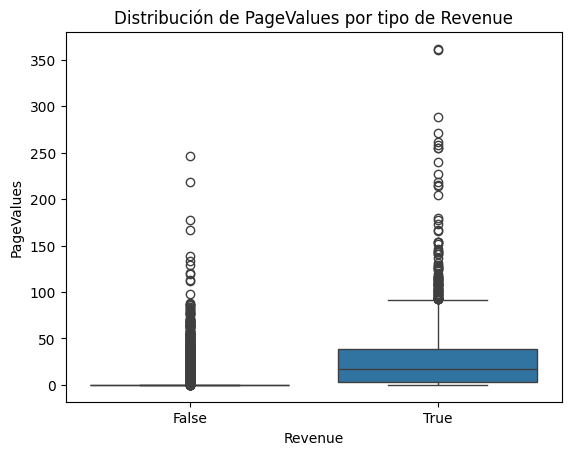

In [76]:
display(df_data.groupby("Revenue").describe()["PageValues"])
sns.boxplot(data=df_data, x="Revenue", y="PageValues")
plt.title("Distribución de PageValues por tipo de Revenue")
plt.show()

El gráfico de arriba indica que las sesiones que concluyeron en una compra efectivamente tiene relación con *PageValues*, pero la información mostrada no es concluyente. Se propone validar si *PageValues* solo es 0 cuando **no** hay compra y mayor que cero cuando hay compra.

In [77]:
rev_pv_my0 = df_data[(df_data["Revenue"]) & (df_data["PageValues"] > 0)].shape[0]
rev_pv_ig0 = df_data[(df_data["Revenue"]) & (df_data["PageValues"] == 0)].shape[0]

notRev_pv_my0 = df_data[(~df_data["Revenue"]) & (df_data["PageValues"] > 0)].shape[0]
notRev_pv_ig0 = df_data[(~df_data["Revenue"]) & (df_data["PageValues"] == 0)].shape[0]

df_temp_5 = pd.DataFrame({
    "Q PageValue > 0": [rev_pv_my0, notRev_pv_my0],
    "Q PageValue = 0": [rev_pv_ig0, notRev_pv_ig0]
}, index=["Compradores", "No Compradores"])

print(f'{rev_pv_my0} registros tienen Revenue y PageValues > 0')
print(f'{rev_pv_ig0} registros tienen Revenue y PageValues = 0')

print(f'{notRev_pv_my0} registros NO tienen Revenue y PageValues > 0')
print(f'{notRev_pv_ig0} registros NO tienen Revenue y PageValues = 0')

display(df_temp_5)

1538 registros tienen Revenue y PageValues > 0
370 registros tienen Revenue y PageValues = 0
1192 registros NO tienen Revenue y PageValues > 0
9216 registros NO tienen Revenue y PageValues = 0


,Q PageValue > 0,Q PageValue = 0
Compradores,1538,370
No Compradores,1192,9216


El dataframe de arriba desvalida la hipótesis de arriba. Existen registros que no terminaron en compra y tiene un PageValue > 0. Tambien existen registros donde se realizaron compras con PageValue igual a 0. 

Con esta nueva información se propone conocer la distribución de compradores y no compradores en función del valor de la PageValue segmentado en las dos categorías

In [78]:
df_temp_6 = df_temp_5.transpose().reset_index().rename(columns={"index":"Cat_PageValue"})
df_temp_6["% Compradores"] = round((df_temp_6["Compradores"] / (df_temp_6["Compradores"] + df_temp_6["No Compradores"]))*100,2)
df_temp_6["% No Compradores"] = round((df_temp_6["No Compradores"] / (df_temp_6["Compradores"] + df_temp_6["No Compradores"]))*100,2)
df_temp_6

,Cat_PageValue,Compradores,No Compradores,% Compradores,% No Compradores
0,Q PageValue > 0,1538,1192,56.34,43.66
1,Q PageValue = 0,370,9216,3.86,96.14


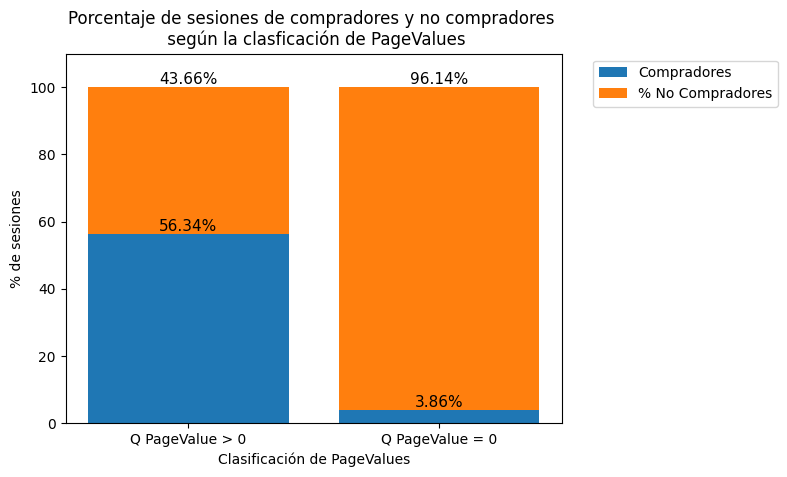

In [79]:
bars1 = plt.bar(df_temp_6["Cat_PageValue"], df_temp_6["% Compradores"], label = "Compradores")
bars2 = plt.bar(df_temp_6["Cat_PageValue"], df_temp_6["% No Compradores"], bottom = df_temp_6["% Compradores"], label="% No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_6["% Compradores"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_6["% No Compradores"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Clasificación de PageValues")
plt.title("Porcentaje de sesiones de compradores y no compradores \n según la clasficación de PageValues")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Mas de la mitad de registros con *PageValues* mayor a 0 están relacionados a una sesión que culminó en compra. Esto es prueba suficiente que existe una correlación fuerte entre las variables *PageValues* y *Revenue*

### Análisis temporal
En la sección a continuación se intenta determinar si las variables temporales:
* Month
* Weekend

Mantiene una correlación con la variable objetivo *Revenue*

#### Month

In [80]:
df_temp_7 = pd.DataFrame(df_data.groupby(by=["Month", "Revenue"])["ProductRelated"].count()).reset_index()
df_temp_7["Revenue"] =np.where(df_temp_7["Revenue"], "Comprador", "No Comprador")
df_temp_7.rename(columns={"ProductRelated":"SessionCount"}, inplace=True)
df_temp_7.head()

C:\Users\Angel\AppData\Local\Temp\ipykernel_5072\4072768265.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Month,Revenue,SessionCount
0,Feb,No Comprador,181
1,Feb,Comprador,3
2,Mar,No Comprador,1702
3,Mar,Comprador,192
4,May,No Comprador,2998


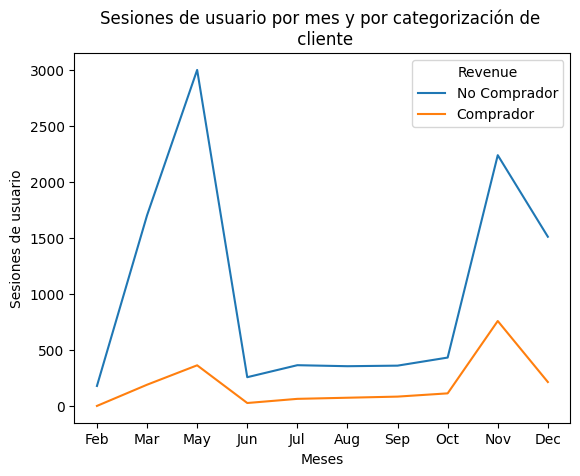

In [81]:
sns.lineplot(data=df_temp_7, x="Month", y="SessionCount", hue="Revenue")
plt.xlabel("Meses")
plt.ylabel("Sesiones de usuario")
plt.title("Sesiones de usuario por mes y por categorización de \n cliente")
plt.show()

Se destacan picos importantes en las compras en los meses de Mayo y Novimebre. Considerando que el dataset incluye data acerca de las promociones en la variable *SpecialDay* se grafica esta en función del tiempo.

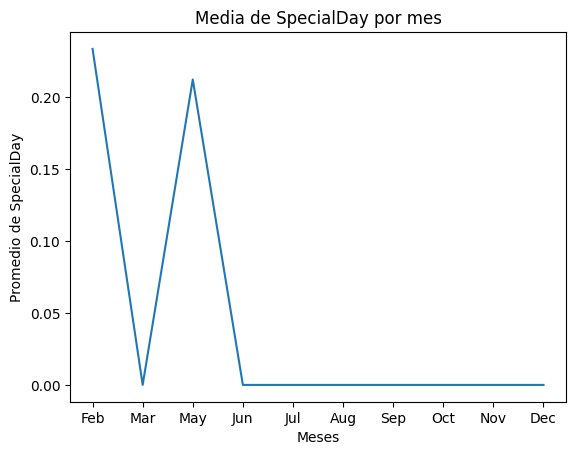

In [82]:
df_temp_8 = pd.DataFrame(df_data.groupby(by=["Month"], observed=False)["SpecialDay"].mean()).reset_index()
sns.lineplot(data=df_temp_8, x="Month", y="SpecialDay")
plt.ylabel("Promedio de SpecialDay")
plt.xlabel("Meses")
plt.title("Media de SpecialDay por mes")
plt.show()

Las gráficas aportan información interesante con respecto al negocio. Se entienden los picos de venta:
* En mayo a razón de la cantidad de promociones 
* En noviembre y diciembre por las compras de navidad

Esta información no es realmente concluyente como para afirmar la existencia de una correlación fuerte entre *Month* y *Revenue*. No es necesario incluir esta variable en el modelo de clasificación propuesto más adelante.

#### Weekend

In [83]:
df_temp_9 = pd.DataFrame(df_data.groupby(by=["Weekend", "Revenue"]).count()["ProductRelated"]).reset_index()
df_temp_9["Weekend"] = np.where(df_temp_9["Weekend"], "Fin de semana", "Lun-Vie")
df_temp_9["Revenue"] = np.where(df_temp_9["Revenue"], "Comprador", "No Comprador")
df_temp_9

,Weekend,Revenue,ProductRelated
0,Lun-Vie,No Comprador,8042
1,Lun-Vie,Comprador,1409
2,Fin de semana,No Comprador,2366
3,Fin de semana,Comprador,499


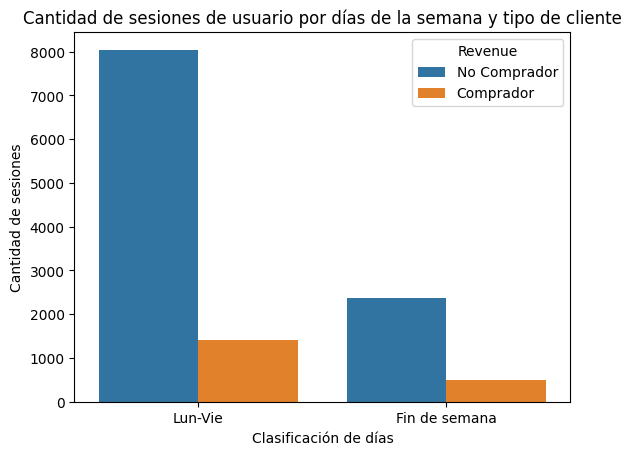

In [84]:
sns.barplot(data=df_temp_9, x="Weekend", y="ProductRelated", hue="Revenue")
plt.xlabel("Clasificación de días")
plt.ylabel("Cantidad de sesiones")
plt.title("Cantidad de sesiones de usuario por días de la semana y tipo de cliente")
plt.show()

El gráfico anterior no es concluyente para determinar una relación entre *Weekend* y *Revenue*, se propone analizar los porcentajes que representa cada clase por la clásificación de los días de la semana.

In [85]:
df_temp_10 = df_temp_9.pivot(index='Weekend', columns='Revenue', values='ProductRelated').reset_index()
df_temp_10.columns.name = None
df_temp_10["% Comprador"] = round((df_temp_10["Comprador"] /(df_temp_10["Comprador"] + df_temp_10["No Comprador"]))*100,2)
df_temp_10["% No Comprador"] = round((df_temp_10["No Comprador"] /(df_temp_10["Comprador"] + df_temp_10["No Comprador"]))*100,2)
df_temp_10

,Weekend,Comprador,No Comprador,% Comprador,% No Comprador
0,Fin de semana,499,2366,17.42,82.58
1,Lun-Vie,1409,8042,14.91,85.09


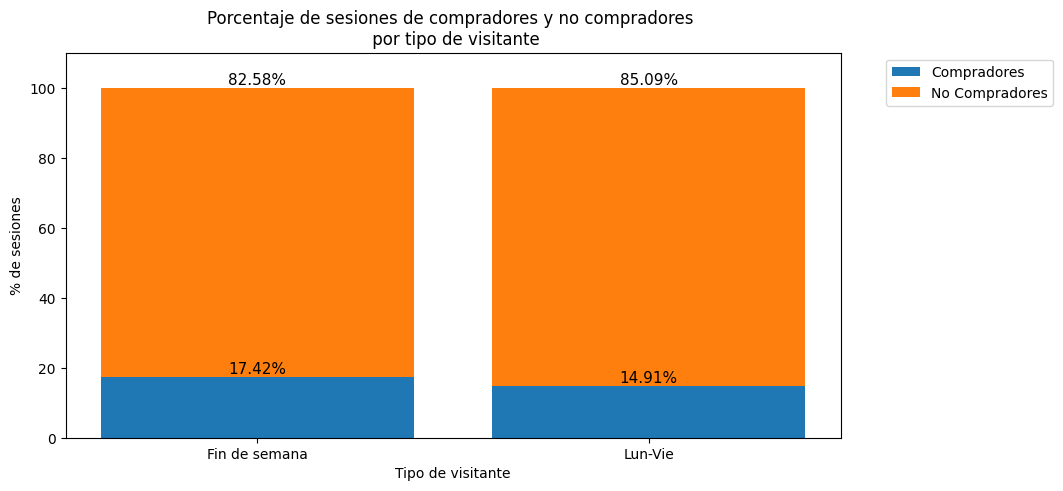

In [86]:
plt.figure(figsize=(10,5))

bars1 = plt.bar(df_temp_10["Weekend"], df_temp_10["% Comprador"], label="Compradores")
bars2 = plt.bar(df_temp_10["Weekend"], df_temp_10["% No Comprador"] , bottom=df_temp_10["% Comprador"], label="No Compradores")

text_size = 11
for bar, value in zip(bars1, df_temp_10["% Comprador"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

for bar, value in zip(bars2, df_temp_10["% No Comprador"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(), f"{value:.2f}%", ha='center', va='bottom', fontsize=text_size)

plt.ylim(0,110)
plt.ylabel("% de sesiones")
plt.xlabel("Tipo de visitante")
plt.title("Porcentaje de sesiones de compradores y no compradores \n por tipo de visitante")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Del gráfico se puede concluir que existe un porcentaje más alto de sesiones que realizan compras durante los fines de semana y en conjunto con el gráfico anterior se podría asumir que los clientes buscan y definen los productos a comprar de lunes a viernes, generando la compra entre sábado y domingo.

La relación no es necesariamente fuerte pero está presenta está variable se debe incluir en el modelo predictivo

Existen más varibles categóricas que podrían mostrar detalles más intrínsecos del negocio como el sistema operativo prefereido de los usuarios o el tipo de navegador entre otros, pero con el fin de cumplir las tareas solicitadas se plantea a continuación un modelo predictivo inicial del cual obtendremos las *Key Features*. 

De esta forma se puede validar el análisis exploratorio realizado hasta este punto y completarlo de ser el caso

In [87]:
df_data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


c:\Python3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 111'. Pick better value with 'binwidth'.


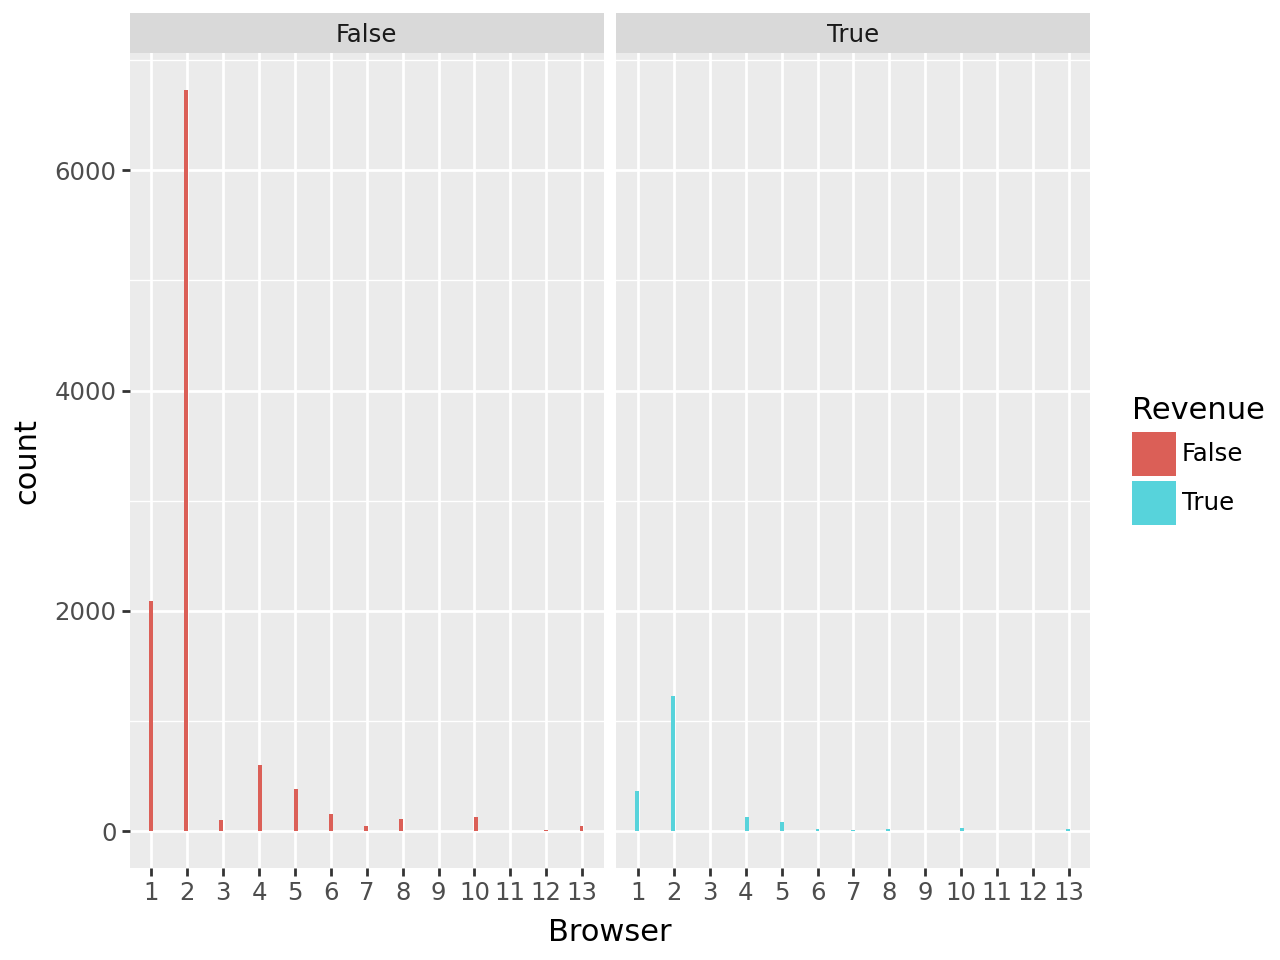

In [88]:
(
    ggplot(df_data) + 
    geom_histogram(mapping= aes("Browser", fill = "Revenue")) + 
    facet_wrap("~Revenue")
)

In [89]:
df_data["VisitorType"].unique()

['Returning_Visitor', 'New_Visitor', 'Other']
Categories (3, object): ['Returning_Visitor', 'New_Visitor', 'Other']

c:\Python3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.


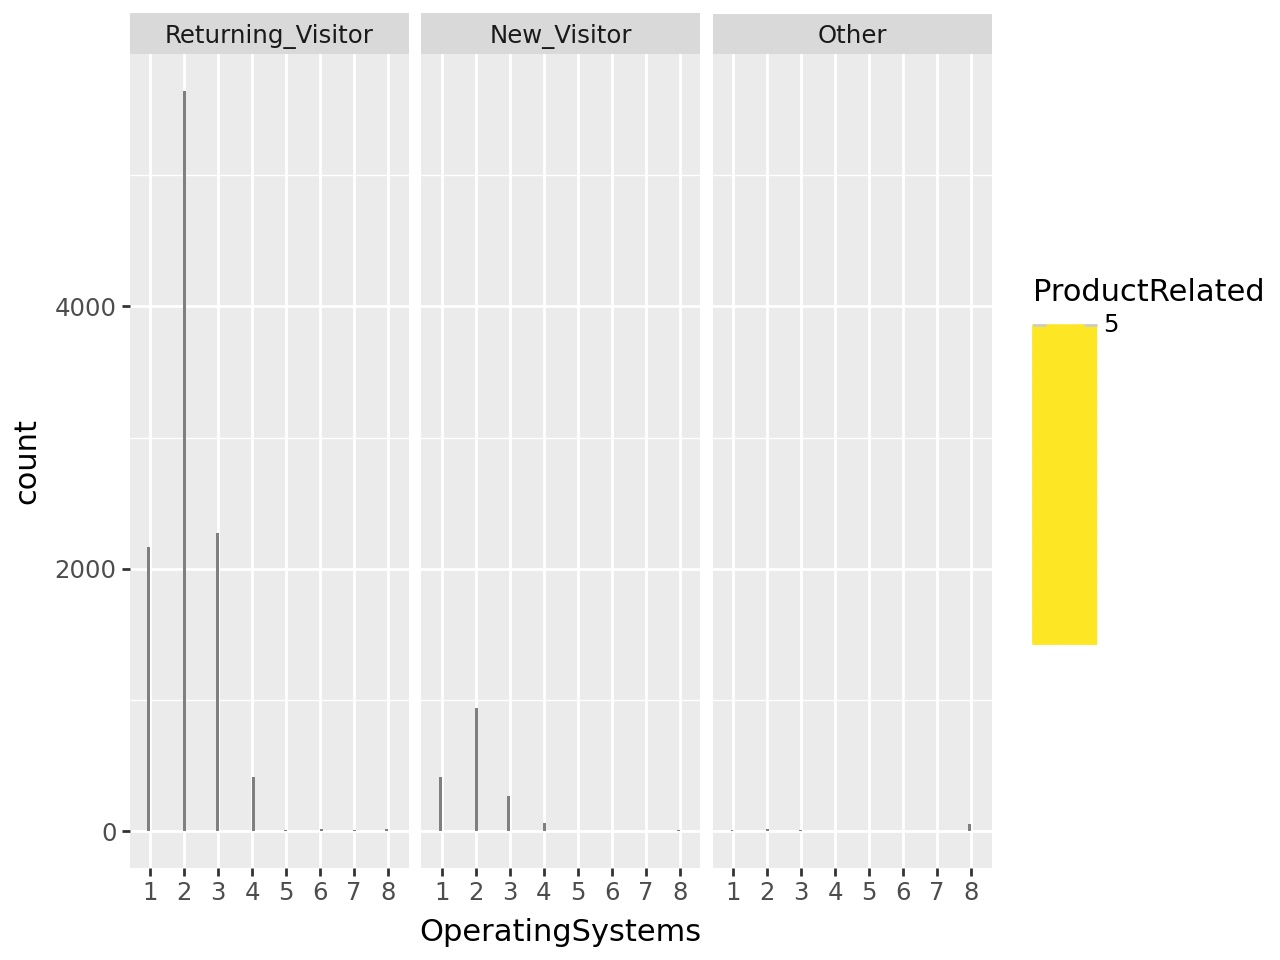

In [90]:
(
    ggplot(df_data) + 
    geom_histogram(mapping= aes("OperatingSystems", fill = "ProductRelated")) + 
    facet_wrap("~VisitorType")
)

# Modelo Predictivo

## Preparar los datasets

In [91]:
# !pip install scikit-learn
SEED = 1508
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump, load

Definir variables X, y para el modelo predictivo: 
* X: Todas las variables excepto *Month* y la variable objetivo *Revenue*
* y: Unicamente la varaible objetivo *Revenue* 

In [92]:
X = df_data.drop(columns=["Month", "Revenue"])
y = df_data["Revenue"]

* Separar en datasets de entramiento y prueba
* Asignar dummies
* Entrenar modelo

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=["OperatingSystems",
                                           "Browser",
                                           "Region",
                                           "TrafficType",
                                           "VisitorType"]
                        )

X_test = pd.get_dummies(X_test, columns=["OperatingSystems",
                                           "Browser",
                                           "Region",
                                           "TrafficType",
                                           "VisitorType"]
                        )

In [94]:
df_metricas = pd.DataFrame({
    "Modelos" : ["Random Forest", "Random Forest GSCV", "Regresión Logística", "Regresión Logística GSCV", "MLP", "MLP GSCV"],
    "AUC ROC": [0,0,0,0,0,0],
    "Accuracy": [0,0,0,0,0,0],
    "Precision": [0,0,0,0,0,0],
    "Recall":[0,0,0,0,0,0]

})
df_metricas = df_metricas.transpose()
df_metricas.columns = df_metricas.iloc[0]
df_metricas = df_metricas.drop(df_metricas.index[0]).reset_index().rename(columns={"index":"Métricas"})
df_metricas.columns.name = None
# df_metricas

## Random Forest

Se instancian dos modelos: 
1. Modelo de clasificación Random Forest
2. Modelo de clasificación Random Forest ajustado los hiperparámetros mediante GridSearchCV

Se entrena el primer modelo

In [95]:
params = {"n_estimators" : [10, 50, 100, 200], "max_depth" : [5, 7, 9], "max_features": [10, "sqrt"]}
RFClassifier = RandomForestClassifier(random_state=SEED)
RFClassifier_grid = GridSearchCV(RFClassifier, params, cv=3, n_jobs=1)
RFClassifier_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1508),
             n_jobs=1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

### Métricas Random Forest sin GridSearchCV

Accuracy de data de entrenameinto 1.0
Accuracy de data de prueba 0.901
AUC ROC: 0.912


,False,True,accuracy
precision,0.919124,0.753695,0.900947
recall,0.967980,0.534965,0.900947
f1-score,0.942920,0.625767,0.900947
support,3123.000000,572.000000,0.900947


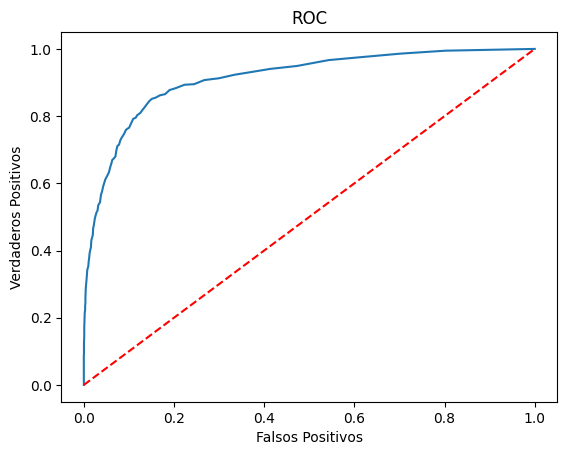

In [96]:
RFClassifier.fit(X_train, y_train)
y_pred_rf = RFClassifier.predict(X_test)
y_test_prob = RFClassifier.predict_proba(X_test)
score_train = RFClassifier.score(X_train, y_train) #score con data de entrenamiento ACCURACY!
score_test = RFClassifier.score(X_test, y_test) #score con data de prueba ACCURACY!
auc = roc_auc_score(y_test, y_test_prob[:,1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

matriz_confusion = confusion_matrix(y_test, y_pred_rf)
# print(matriz_confusion)

conf_mtrx = confusion_matrix(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, output_dict=True)

df_metricas["Random Forest"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

- La diferencia que existe entre la exactitud de entramiento 1.0 y la de prueba 0.901 permite concluir que el modelo no está en sobreajuste
- El valor AUC ROC: 0.912 se considera realmente bueno para ser un modelo sin ajuste por hiperparámetros
- A pesar de tener valores de exactitud y AUC ROC sobre 0.9 la precisión del modelo no alcanza un 76% (75.36%). Su contraparte, la precisión para predecir negativos tiene un valor de 91.91%. Esto permite concluir que el modelo es mejor para predecir sesiones de no compradores.

#### Key Features

A continuación se verifican las variables analizadas mediante la propiedad Key Features del modelo Random Forest.

,Feature,Relevance
8,PageValues,3.440669e-01
5,ProductRelated_Duration,8.957987e-02
7,ExitRates,8.538107e-02
4,ProductRelated,7.468992e-02
1,Administrative_Duration,5.843922e-02
...,...,...
58,TrafficType_18,6.234930e-06
17,OperatingSystems_7,5.392805e-07
52,TrafficType_12,0.000000e+00
57,TrafficType_17,0.000000e+00


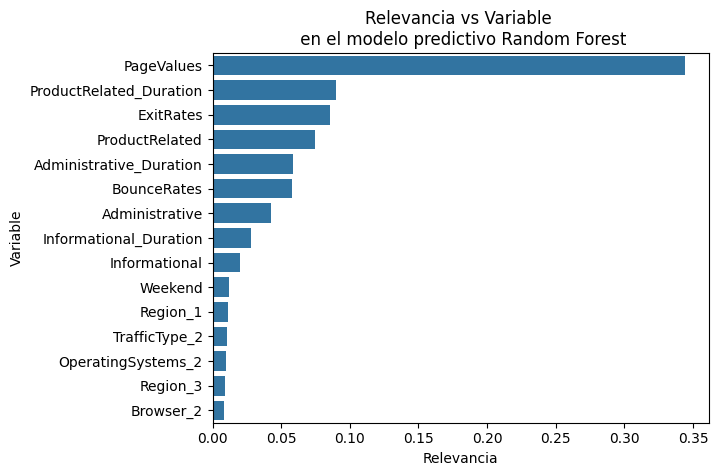

In [97]:
relevances = RFClassifier.feature_importances_
df_features = pd.DataFrame({
    "Feature": X_train.columns,
    "Relevance": relevances
})
df_features = df_features.sort_values(by=["Relevance"], ascending=False)
display(df_features)

sns.barplot(data=df_features.iloc[:15], x="Relevance", y="Feature")
plt.ylabel("Variable")
plt.xlabel("Relevancia")
plt.title("Relevancia vs Variable \n en el modelo predictivo Random Forest")
plt.show()

Esta gráfica valida nuestro análisis exploratorio y da la razón al no haber explorado y analizado las variables categóricas ya que el impacto causado en *Revenue* es mínimo. 

### Métricas Random Forest con GridSearchCV

Se entrena el segundo modelo con los hiperparámetros ajustados y se obtienen sus métricas. Se espera estas sean mejores a las del modelo sin ajuste.

Accuracy de data de entrenameinto 0.928
Accuracy de data de prueba 0.9
AUC ROC: 0.914


,False,True,accuracy
precision,0.913017,0.781163,0.900135
recall,0.974704,0.493007,0.900135
f1-score,0.942853,0.604502,0.900135
support,3123.000000,572.000000,0.900135


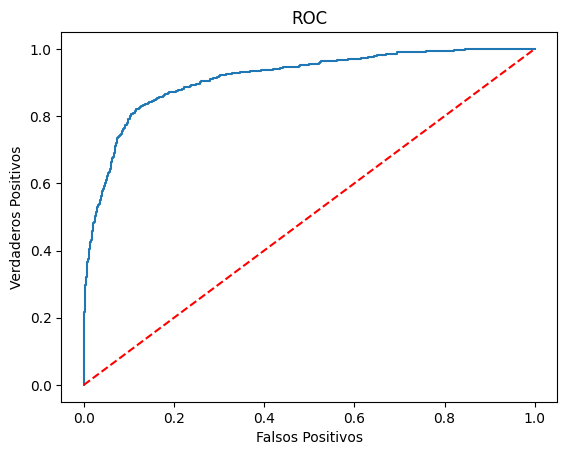

In [98]:
y_pred = RFClassifier_grid.predict(X_test)
y_test_prob = RFClassifier_grid.predict_proba(X_test)
score_train = RFClassifier_grid.score(X_train, y_train)
score_test = RFClassifier_grid.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

df_metricas["Random Forest GSCV"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

- Una vez más la exactitud y el valor AUC ROC están sobre 0.9, pero el modelo podría esta sobre ajustado ya que la diferencia entre la exactitud de entrenamiento y la de prueba no es significativa.
- Se ha mejorado la precisión del modelo en aproximadamente tres puntos porcentuales, evidentemente castigando la sensibilidad y el puntaje-f1. 
- Es muy probable que no se consigan mejores resultados que los mostrados arriba, el problema es el desbalance de la data. Existen 3123 sesiones de no compradores contra 572 sesiones de compradores.

## Regresion Logística

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
params = {
    'penalty': ['l1', 'l2'],            
    'C': [0.001, 0.01, 0.1, 1, 10],     
    'solver': ['liblinear', 'saga'],    
    # 'max_iter': [500, 1000, 1500]
}
LRClassifier = LogisticRegression(random_state=SEED)
LRClassifier_grid = GridSearchCV(LRClassifier, params, cv=3, n_jobs=1)


### Métricas Regresión Logística sin GridSearchCV

Accuracy de data de entrenameinto 0.881
Accuracy de data de prueba 0.884
AUC ROC: 0.877


c:\Python3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,False,True,accuracy
precision,0.897081,0.733553,0.883627
recall,0.974063,0.389860,0.883627
f1-score,0.933988,0.509132,0.883627
support,3123.000000,572.000000,0.883627


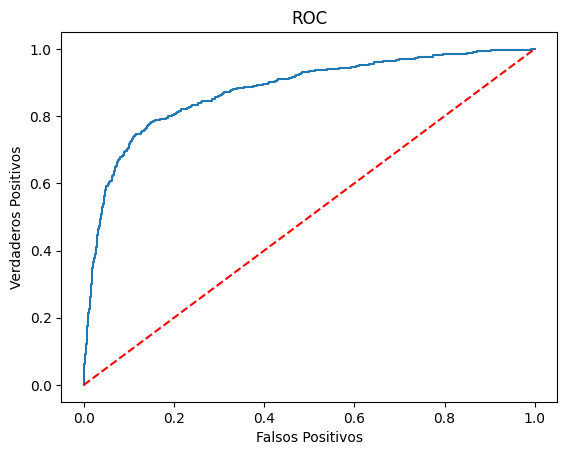

In [101]:
LRClassifier.fit(X_train, y_train)
y_pred = LRClassifier.predict(X_test)
y_test_prob = LRClassifier.predict_proba(X_test)
score_train = LRClassifier.score(X_train, y_train)
score_test = LRClassifier.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_metricas["Regresión Logística"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

Conociendo ya valores para AUC ROC, exactitud y precisión de otros modelos se puede descartar este modelo de regresión logísitica como opción, ya que el modelo Random Forest de arriba supera las métricas. Se aplica a continuación el ajuste de hiperparámetros mediante GridSearchCV

### Métricas Regresión Logística con GridSearchCV

c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter w

Accuracy de data de entrenameinto 0.886
Accuracy de data de prueba 0.889
AUC ROC: 0.856


c:\Python3.11\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


,False,True,accuracy
precision,0.898824,0.772881,0.888769
recall,0.978546,0.398601,0.888769
f1-score,0.936992,0.525952,0.888769
support,3123.000000,572.000000,0.888769


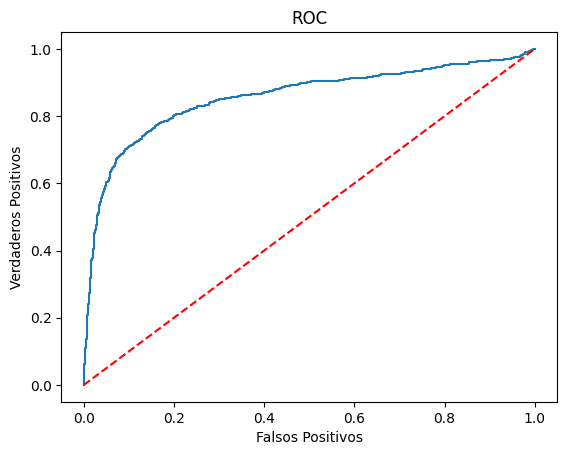

In [102]:
LRClassifier_grid.fit(X_train, y_train)
y_pred = LRClassifier_grid.predict(X_test)
y_test_prob = LRClassifier_grid.predict_proba(X_test)
score_train = LRClassifier_grid.score(X_train, y_train)
score_test = LRClassifier_grid.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_metricas["Regresión Logística GSCV"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

El modelo con hiperparámetros ajustados tiene mejor precisión. Se cree que este modelo es mejor a pesar de tener un valor menor de AUC ROC.

## MLP

In [103]:
from sklearn.neural_network import MLPClassifier

In [104]:
params = {
    'solver': ['lbfgs'], 
    'max_iter': [100,200,300], # Iteraciones máximas en cada red
    'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
    'hidden_layer_sizes':[30,50,70], # Número de neuronas en cada capa
    'random_state':[SEED]
}
neural_model = MLPClassifier(random_state=SEED)
neural_model_grid = GridSearchCV(neural_model, param_grid=params, cv=3, scoring="roc_auc", n_jobs=-1, verbose=10)

### Métricas MLP sin GridSearchCV

Accuracy de data de entrenameinto 0.728
Accuracy de data de prueba 0.714
AUC ROC: 0.817


,False,True,accuracy
precision,0.957871,0.331250,0.713667
recall,0.691643,0.833916,0.713667
f1-score,0.803273,0.474155,0.713667
support,3123.000000,572.000000,0.713667


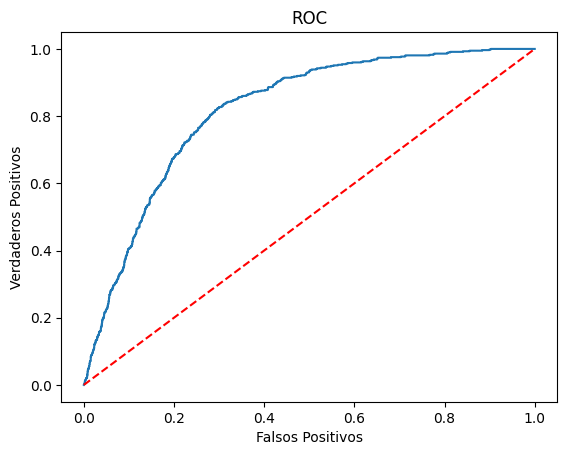

In [105]:
neural_model.fit(X_train, y_train)
y_pred = neural_model.predict(X_test)

y_test_prob = neural_model.predict_proba(X_test)
score_train = neural_model.score(X_train, y_train)
score_test = neural_model.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

df_metricas["MLP"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()


La curva ROC del modelo indica que existe una *zona* en el dominio donde el clasificador se comportar de forma aleatoria. Siendo este el caso es imposible tomar en cuenta los resultados obtenidos sin antes mejorarlos mediante GridSearchCV

### Métricas MLP con GridSearchCV

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Python3.11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Accuracy de data de entrenameinto 0.88
Accuracy de data de prueba 0.882
AUC ROC: 0.883


c:\Python3.11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


,False,True,accuracy
precision,0.895263,0.729730,0.882003
recall,0.974384,0.377622,0.882003
f1-score,0.933149,0.497696,0.882003
support,3123.000000,572.000000,0.882003


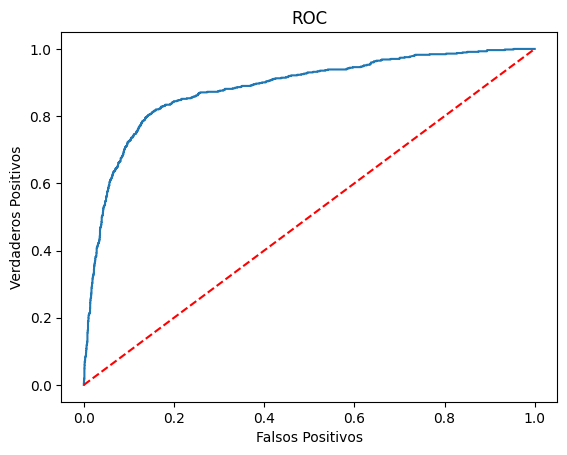

In [106]:
neural_model_grid.fit(X_train, y_train)
# print(neural_model_grid.best_params_, f"ROC AUC: {round(neural_model_grid.best_score_,3)}")
best_neural_model = MLPClassifier(**neural_model_grid.best_params_)

best_neural_model.fit(X_train, y_train)
y_pred = best_neural_model.predict(X_test)

y_test_prob = best_neural_model.predict_proba(X_test)
score_train = best_neural_model.score(X_train, y_train)
score_test = best_neural_model.score(X_test, y_test)
auc = roc_auc_score(y_test, y_test_prob[:, 1])

print(f"Accuracy de data de entrenameinto {round(score_train,3)}")
print(f"Accuracy de data de prueba {round(score_test,3)}")
print(f"AUC ROC: {round(auc,3)}")

conf_mtrx = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_metricas["MLP GSCV"] = [round(auc,3), round(score_test, 3), round(report["True"]["precision"], 3), round(report["True"]["recall"], 3)]
# df_metricas

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

El clásificador ya no se comporta de forma aleatoria. Esto mejora el valor de AUC ROC a 0.885, este clasificador es mejor al anterior a pesar de tener una presición menor 73.70%, pero no se comporta de forma aleatoria.

# Evaluación de Modelos Predictivos

Después de entrenar, probar y obtener las métricas para los modelos de clasificación
* Random Forest
* Regresión Logística
* MLP

Se determina en esta sección le mejor modelo basandose en sus métricas


In [107]:
df_metricas_t = df_metricas.transpose()
df_metricas_t.drop(df_metricas_t.index[0], inplace=True)
df_metricas_t.rename(columns={0:"AUC ROC", 1:"Accuracy", 2:"Precision", 3:"Recall"}, inplace=True)
df_metricas_t

,AUC ROC,Accuracy,Precision,Recall
Random Forest,0.912,0.901,0.754,0.535
Random Forest GSCV,0.914,0.9,0.781,0.493
Regresión Logística,0.877,0.884,0.734,0.39
Regresión Logística GSCV,0.856,0.889,0.773,0.399
MLP,0.817,0.714,0.331,0.834
MLP GSCV,0.883,0.882,0.73,0.378


Para poder visualizar de forma comparativa cada una de las métricas se realizan gráficos de barra por modelo. De esta forma es posible determinar si existen diferencias significativas en cada una de las métricas de los modelos y de esta forma determinar el mejor modelo predictivo de clasificación

C:\Users\Angel\AppData\Local\Temp\ipykernel_5072\318827038.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\Angel\AppData\Local\Temp\ipykernel_5072\318827038.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\Angel\AppData\Local\Temp\ipykernel_5072\318827038.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\Angel\AppData\Local\Temp\ipykernel_5072\318827038.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


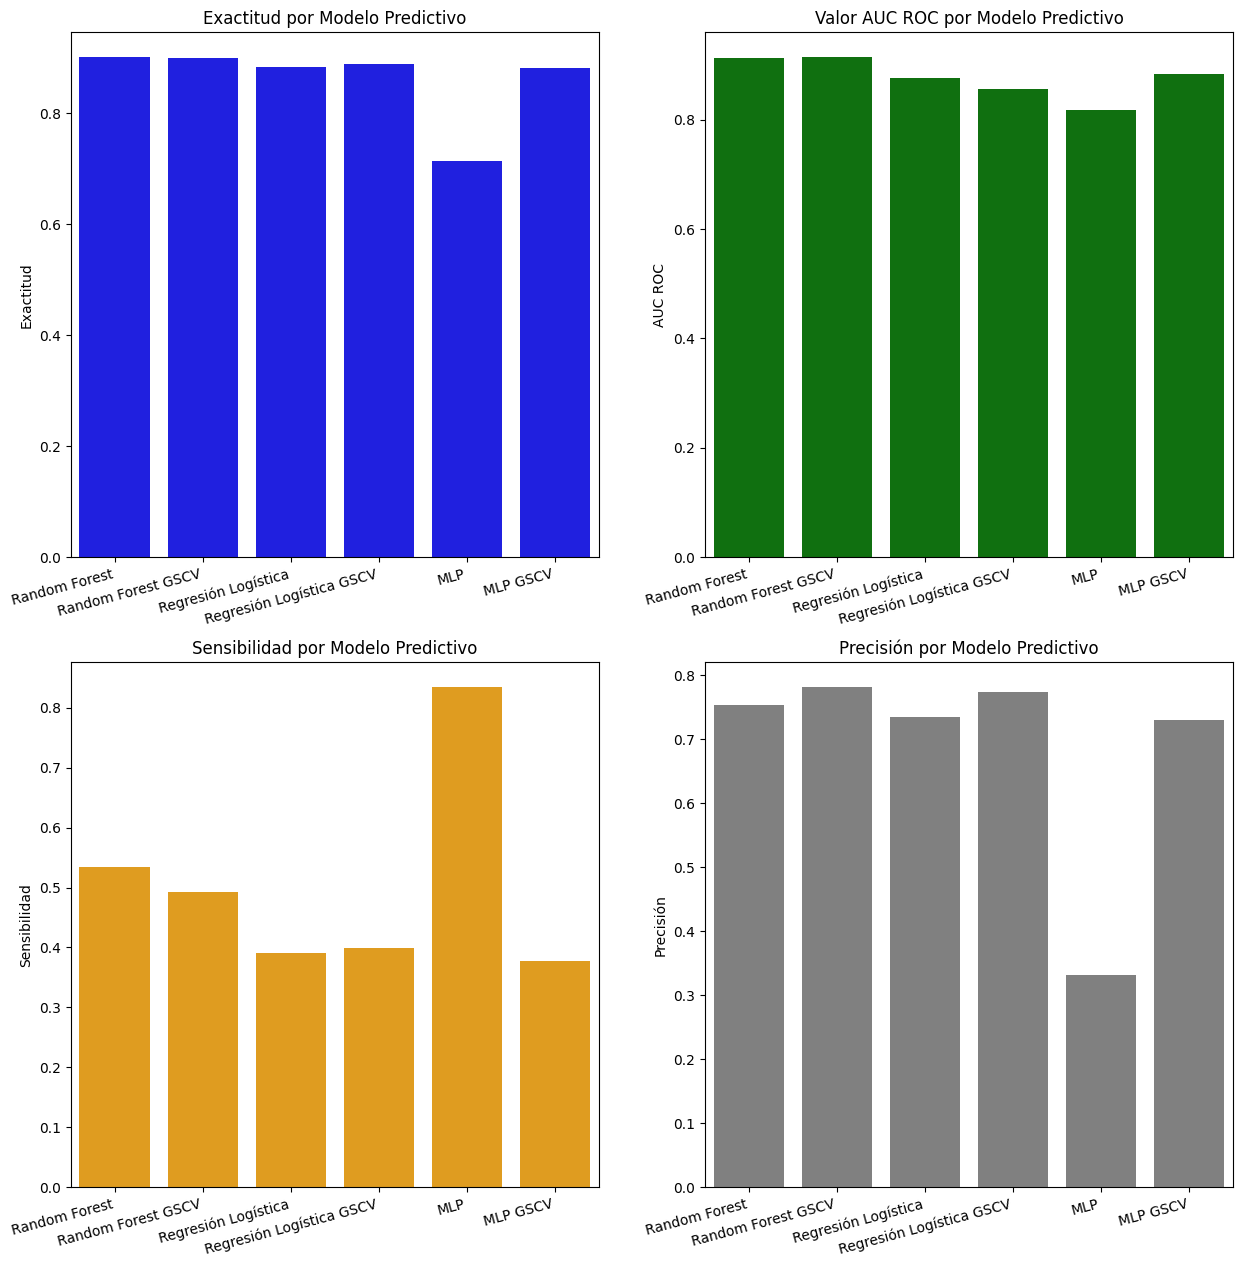

In [108]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.barplot(data=df_metricas_t, x=df_metricas_t.index, y="AUC ROC", ax=axes[0][1], color="green")

axes[0][1].set_xticklabels(labels=df_metricas_t.index, rotation=15, ha="right")
axes[0][1].set_xlabel("")
axes[0][1].set_ylabel("AUC ROC")
axes[0][1].set_title("Valor AUC ROC por Modelo Predictivo")

sns.barplot(data=df_metricas_t, x=df_metricas_t.index, y="Accuracy", ax=axes[0][0], color="blue")

axes[0][0].set_xticklabels(labels=df_metricas_t.index, rotation=15, ha="right")
axes[0][0].set_xlabel("")
axes[0][0].set_ylabel("Exactitud")
axes[0][0].set_title("Exactitud por Modelo Predictivo")

sns.barplot(data=df_metricas_t, x=df_metricas_t.index, y="Precision", ax=axes[1][1], color="gray")

axes[1][1].set_xticklabels(labels=df_metricas_t.index, rotation=15, ha="right")
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("Precisión")
axes[1][1].set_title("Precisión por Modelo Predictivo")

sns.barplot(data=df_metricas_t, x=df_metricas_t.index, y="Recall", ax=axes[1][0], color="orange")

axes[1][0].set_xticklabels(labels=df_metricas_t.index, rotation=15, ha="right")
axes[1][0].set_xlabel("")
axes[1][0].set_ylabel("Sensibilidad")
axes[1][0].set_title("Sensibilidad por Modelo Predictivo")

plt.show()



- El gráfico de la exactitud indica a primera vista que la exactitud es mejor para los modelos Random Forest. Realmente no se puede visualizar una diferencia significativa entre la exactitud de todos los modelos. Esta metrica no es suficiente ni excluyente para ningún modelo, pero da un indicio mostrando que el mejor modelo de los 3 evaluados es Random Forest.

- En la gráfica del valor AUC_ROC se muestra una diferencia importante para los modelos Random Forest. Esto confirma el indicio anterior y justifica un primer criterio de exclusión para el resto de modelos. Sin embargo no se considera definitivo y se analizan las demás métricas.

- La sensibilidad es la métrica que mayor diferencia muestra entre los modelos evaluados. Los modelos más sensibles son Random Forest con y sin ajuste de hiperparámetros. Esta métrica permite excluir los modelos MLP ya que su sensibilidad es la más baja.

- A pesar que el modelo MLP sin ajuste muestra una alta precisión, no se puede concluir que es un buen modelo pues en el resto de métricas no destaca, es más la sensibilidad del mismo al ser más baja excluye al modelo. Por otra parte los modelos Random Forest muestran precisión alrededor del 74%, siendo los segundo y tercer valor más alto. Esta métrica se considera suficiente para excluir los modelos de Regresión Logística

En base a las conclusiones de arriba se determina que el mejor modelos es Random Forest con ajuste de hiperparámetros.

# Umbralización

In [109]:
y_test_pred_prob = RFClassifier_grid.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(y_test == 0)[0]]

In [110]:
def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', normed=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = normed, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = normed, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

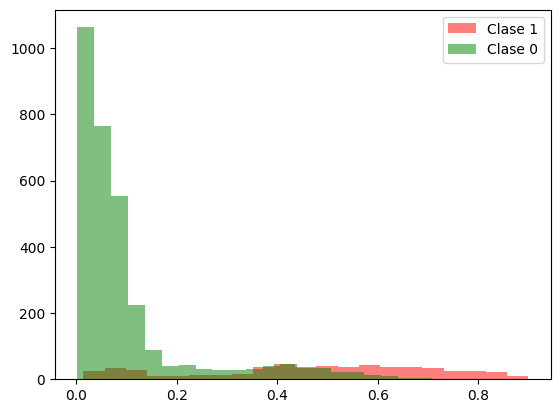

In [111]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, normed=0)

,False,True,accuracy
precision,0.890100,0.900000,0.890663
recall,0.993276,0.330420,0.890663
f1-score,0.938862,0.483376,0.890663
support,3123.000000,572.000000,0.890663


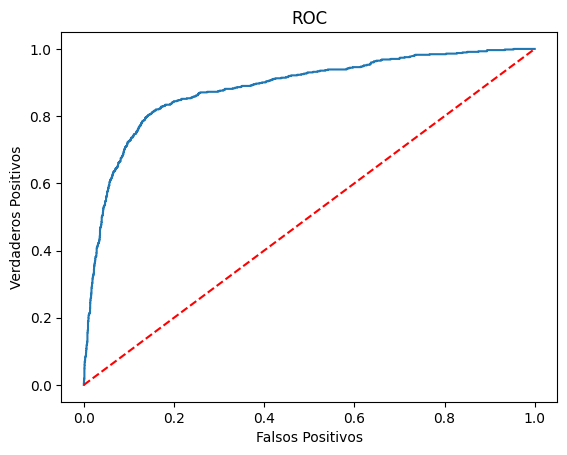

In [112]:
umbral = 0.6
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
conf_mtrx = confusion_matrix(y_test, y_umbralizadas)
report = classification_report(y_test, y_umbralizadas, output_dict=True)

df_report = pd.DataFrame(report)
display(df_report[["False", "True", "accuracy"]])

fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

In [113]:
df_metricas_t

,AUC ROC,Accuracy,Precision,Recall
Random Forest,0.912,0.901,0.754,0.535
Random Forest GSCV,0.914,0.9,0.781,0.493
Regresión Logística,0.877,0.884,0.734,0.39
Regresión Logística GSCV,0.856,0.889,0.773,0.399
MLP,0.817,0.714,0.331,0.834
MLP GSCV,0.883,0.882,0.73,0.378


- Teniendo en cuenta las métricas iniciales del modelo Random Forest con ajuste de hiperparámetros por GridSearchCV, es notabla la mejora en la precisión del modelo umbralizando el mismo.

- Tras la umbralización la precisión alcanza 90% ganando aproximadamente doce puntos porcentuales. Este incremento en precisión genera un decremento en la sensibilidad del modelo con un valor de 0.33.

- La métricas indican también que la umbralización no tuvo un impacto fuerte en la exactitud 0.89

- Se puede concluir que la umbralización tiene un impacto positivo en el clasificador predictivo 